# Titanic

This notebook uses supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive.

## Part 1: Exploring the Titanic

The data can be downloaded [here](https://www.kaggle.com/c/titanic/data).

Some helpful information from the website above:

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age | in years |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

**Variable Notes**

`pclass`: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore `parch`=0 for them.

### 1.1: Exploratory Data Analysis

Import necessary modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer

import graphviz

Read in data files:

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Get a sense of the training dataframe using the `DataFrame.info()` method:

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Convert `Sex` into a binary variable, with:
* male = 0
* female = 1

In [4]:
# train Sex
numeric_Sex = np.array([])
for i in range(len(train.index)):
    if train['Sex'][i] == 'male':
        numeric_Sex = np.append(numeric_Sex, 0)
    else:
        numeric_Sex = np.append(numeric_Sex, 1)
        
train['Sex'] = numeric_Sex.astype(np.int64)

# test Sex
numeric_Sex = np.array([])
for i in range(len(test.index)):
    if test['Sex'][i] == 'male':
        numeric_Sex = np.append(numeric_Sex, 0)
    else:
        numeric_Sex = np.append(numeric_Sex, 1)
        
test['Sex'] = numeric_Sex.astype(np.int64)

Convert `Embarked` into three binary categories:

In [5]:
# train embarked
for i in range(len(train.index)):
    if train['Embarked'][i] == 'C':
        train.loc[i, 'Embarked_C'] = 1
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'Q':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 1
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'S':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
    else:
        train.loc[i, 'Embarked_C'] = np.nan
        train.loc[i, 'Embarked_Q'] = np.nan
        train.loc[i, 'Embarked_S'] = np.nan
        
train.drop(columns=['Embarked'], inplace=True)

# test embarked
for i in range(len(test.index)):
    if test['Embarked'][i] == 'C':
        test.loc[i, 'Embarked_C'] = 1
        test.loc[i, 'Embarked_Q'] = 0
        test.loc[i, 'Embarked_S'] = 0
    elif test['Embarked'][i] == 'Q':
        test.loc[i, 'Embarked_C'] = 0
        test.loc[i, 'Embarked_Q'] = 1
        test.loc[i, 'Embarked_S'] = 0
    elif test['Embarked'][i] == 'S':
        test.loc[i, 'Embarked_C'] = 0
        test.loc[i, 'Embarked_Q'] = 0
        test.loc[i, 'Embarked_S'] = 1
    else:
        test.loc[i, 'Embarked_C'] = np.nan
        test.loc[i, 'Embarked_Q'] = np.nan
        test.loc[i, 'Embarked_S'] = np.nan
        
test.drop(columns=['Embarked'], inplace=True)

Get a sense of the range and distribution of the variables:

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,889.000000,889.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.188976,0.086614,0.724409
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.391710,0.281427,0.447063
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


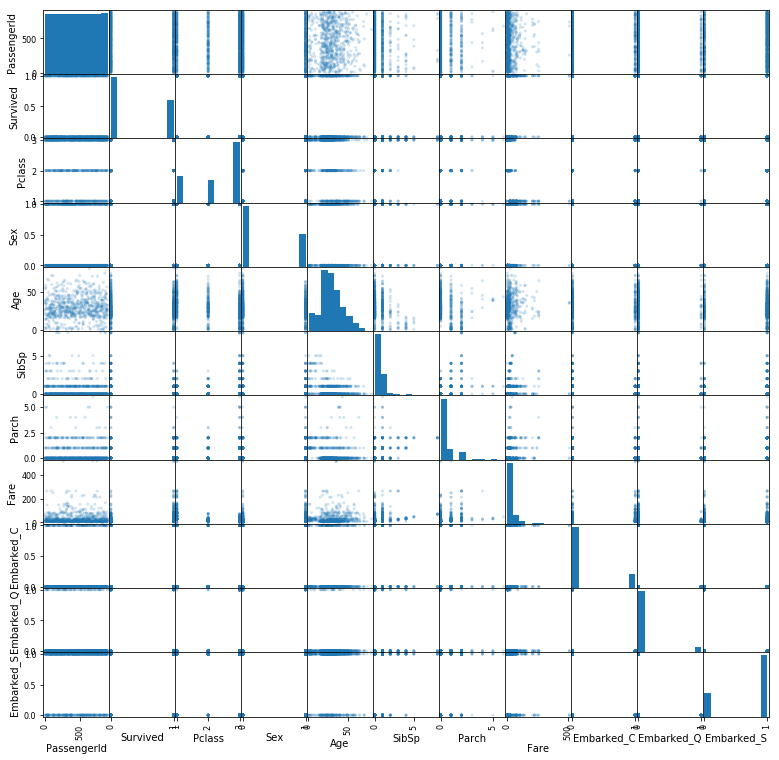

In [7]:
fig = pd.plotting.scatter_matrix(train, figsize=(13,13), alpha=0.2)

As we can see from the scatterplot matrix and summary tables above, `Age`, `Cabin`, and `Embarked` have missing data. Clearly, the data needs to be normalized in order to prevent overweighting of any single variable, since the range of values is very different depending on the category. Finally, the scatter plots above do not reveal any obvious strong collinearity among predictor variables. However, we do observe slight to moderate collinearity between `Age` and `SibSp` (which makes sense, since typically you travel with your siblings when you are young, but only your partner as you get older), between `Age` and `Parch` (which makes sense, because you can only have a maximum of two parents when you are young, but you can have any number of children when you are old), between `Pclass` and `Fare` (which makes sense, because upper class tickets are more expensive), between `Fare` and `SibSp` (which makes sense, since wealthy families tend to have smaller families), and between `Fare` and `Parch` (which makes sense, again since wealthy families tend to have smaller families).

### 1.2: Correlates of Survival

Simply implement a t-test between survivors and non-survivors for each variable. This method does not identify collinearity, but does provide a first-order prediction as to what factors correlate with survival.

In [8]:
# variables we want to test
ttest_vars = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

# separate survived and non-survived
train_survived_0 = train[train['Survived']==0].copy()
train_survived_1 = train[train['Survived']==1].copy()

# storage vectors
stat_vec = np.zeros(len(ttest_vars))
pval_vec = np.zeros(len(ttest_vars))
pass_vec = []

# iterate through the variables
for i in range(len(ttest_vars)):
    
    # do the t-test, dropping empty rows
    stat, pval = stats.ttest_ind(train_survived_0[ttest_vars[i]].dropna(),
                                 train_survived_1[ttest_vars[i]].dropna(),
                                 equal_var=False)
    
    # store
    stat_vec[i] = stat
    pval_vec[i] = pval
    if pval < 0.05:
        pass_vec.append(True)
    else:
        pass_vec.append(False)
    
# create a table
ttest_df = pd.DataFrame({'variable':ttest_vars,'stat':stat_vec,'pval':pval_vec,'significant?':pass_vec})
ttest_df

,variable,stat,pval,significant?
0,PassengerId,0.150406,8.804853e-01,False
1,Pclass,10.336953,2.911155e-23,True
2,Sex,-18.134563,1.243794e-58,True
3,Age,2.046030,4.118965e-02,True
4,SibSp,1.194353,2.326626e-01,False
5,Parch,-2.478908,1.339484e-02,True
6,Fare,-6.839099,2.699332e-11,True
7,Embarked_C,-4.836518,1.691747e-06,True
8,Embarked_Q,-0.134635,8.929382e-01,False
9,Embarked_S,4.420475,1.156630e-05,True


As we can see from the results of the t-test above, many of the variables seem to be significantly correlated (at the 95% confidence level) with survival. In particular, `Pclass`, `Sex`, `Age`, `Parch`, `Fare`, `Embarked_C`, and `Embarked_S` all correlate with survival. However, as discussed in part 1.1, we can see that several of these variables are correlated with one another, so it is not clear from this analysis alone which of these variables are actually 'causal' for survival.

## Part 2: Decision Trees

### 2.1: Data Preparation

Get rid of columns that are either meaningless or require some feature engineering to be useful:

In [9]:
# columns that we actually want
keep_vars = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S','Survived']
train = train[keep_vars]

A function for normalizing the data:

In [10]:
def normalize(array):
    """
    Normalize an array

    Parameters
    ----------
    array : array
        Original array.

    Returns
    -------
    norm_array : array
        Normalized input array.
    """
    # if the array is just one variable
    if array.ndim==1:
        norm_array = (array - np.nanmean(array))/np.nanstd(array)
        
    # if more than one variable
    else:
        norm_array = (array - np.nanmean(array, axis=0))/np.nanstd(array, axis=0)
    
    return norm_array

Normalize everything except for the target:

In [11]:
# normalize
train_norm = train.copy()
for col in train.columns:
    if col!='Survived':
        train_norm[col] = normalize(train[col].values)

Also change `Survived` into -1 and 1, for input into `DecisionTreeClassifier`:

In [12]:
for i in range(len(train_norm.index)):
    if train_norm['Survived'][i] == 0:
        train_norm.loc[i, 'Survived'] = -1

Split into training and validation:

In [13]:
# the features for X
feature_names = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

# get X and Y
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

# training and testing
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

For the training data, try a variety of methods for dealing with NaN data:

* version 1: simply drop rows with NaN
* version 2: impute the mean of all the training data for `Age`, and the mode of all the training data for `Embarked`
* version 3: impute the mean of all rows with the same `SibSp` as the row with the missing data for `Age` (since from Part 1.2 they seem to be well correlated), and the mode of all the training data for `Embarked`

In [ ]:
# get column numbers for features that need imputing
Age_col_ind = feature_names.index('Age')
SibSp_col_ind = feature_names.index('SibSp')
Embarked_C_col_ind = feature_names.index('Embarked_C')
Embarked_Q_col_ind = feature_names.index('Embarked_Q')
Embarked_S_col_ind = feature_names.index('Embarked_S')

# create a mask for rows with NaN
train_NaN_mask = np.isnan(X_train).any(axis=1)
train_NaN_rows = np.where(train_NaN_mask)[0]
train_NaN_Age_rows = np.where(np.isnan(X_train[:,Age_col_ind]))[0]
train_NaN_Embarked_rows = np.where(np.isnan(X_train[:,Embarked_C_col_ind]))[0]

# identify which port had the most people
port_list = ['Embarked_C','Embarked_Q','Embarked_S']
Embarked_C_sum = np.nanmean(X_train[:,Embarked_C_col_ind])
Embarked_Q_sum = np.nanmean(X_train[:,Embarked_Q_col_ind])
Embarked_S_sum = np.nanmean(X_train[:,Embarked_S_col_ind])
Embarked_most = np.argmax(np.array([Embarked_C_sum, Embarked_Q_sum, Embarked_S_sum]))
Embarked_most_col_ind = feature_names.index(port_list[Embarked_most])

# version 1: simply drop rows with NaN data
X_train_1 = X_train[~train_NaN_mask]
Y_train_1 = Y_train[~train_NaN_mask]

# version 2: impute the mean for the age, and the mode for embarked
X_train_2 = X_train.copy()
Y_train_2 = Y_train.copy()
X_train_2[train_NaN_Age_rows,Age_col_ind] = np.nanmean(X_train[:,Age_col_ind])
X_train_2[train_NaN_Embarked_rows,Embarked_C_col_ind] = np.nanmin(X_train[:,Embarked_C_col_ind])
X_train_2[train_NaN_Embarked_rows,Embarked_Q_col_ind] = np.nanmin(X_train[:,Embarked_Q_col_ind])
X_train_2[train_NaN_Embarked_rows,Embarked_S_col_ind] = np.nanmin(X_train[:,Embarked_S_col_ind])
X_train_2[train_NaN_Embarked_rows,Embarked_most_col_ind] = np.nanmax(X_train[:,Embarked_most_col_ind])

# version 3: impute age better (see above), and the mode for embarked
X_train_3 = X_train.copy()
Y_train_3 = Y_train.copy()
for i in train_NaN_Age_rows:
    X_train_3[i,Age_col_ind] = np.nanmean(X_train[X_train[SibSp_col_ind]==X_train[i,SibSp_col_ind]][:,Age_col_ind])
X_train_3[train_NaN_Embarked_rows,Embarked_C_col_ind] = np.nanmin(X_train[:,Embarked_C_col_ind])
X_train_3[train_NaN_Embarked_rows,Embarked_Q_col_ind] = np.nanmin(X_train[:,Embarked_Q_col_ind])
X_train_3[train_NaN_Embarked_rows,Embarked_S_col_ind] = np.nanmin(X_train[:,Embarked_S_col_ind])
X_train_3[train_NaN_Embarked_rows,Embarked_most_col_ind] = np.nanmax(X_train[:,Embarked_most_col_ind])

For the testing data...

A function for calculating accuracy:

In [ ]:
def compute_accuracy(predicted, observed):
    """
    Compute accuracy.

    Parameters
    ----------
    predicted : array
        Predicted values.
        
    observed : array
        Observed values.

    Returns
    -------
    accuracy : float
        The accuracy.
    """
    TP = sum((predicted==1) & (observed==1))
    TN = sum((predicted==-1) & (observed==-1))
    FP = sum((predicted==1) & (observed==-1))
    FN = sum((predicted==-1) & (observed==1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

### 2.1 Decision Tree

The decision tree:

In [ ]:
# fit the tree using default parameters
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on validation data = {:.4f}'.format(accuracy))

Now plot that tree (only showing to a depth of 3):

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

Gini is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Therefore, low gini values indicate better performance.

### 2.2 Tree Tuning

Use all of the data (minus the validation data) to re-fit a single decision tree with max_depth = 4:

Fit the tree:

In [ ]:
# fit the tree with max_depth=4
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, Y_train)

# predict on the training and held-out data
Y_train_predicted = clf.predict(X_train)
Y_test_predicted = clf.predict(X_test)

# accuracy
train_accuracy = compute_accuracy(Y_train_predicted, Y_train)
test_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on training data   = {:.4f}'.format(train_accuracy))
print('accuracy on validation data = {:.4f}'.format(test_accuracy))

Plot:

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

Feature importances:

In [ ]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(feature_names, rotation=45, horizontalalignment='right')

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show(fig)

The tree with a max depth of 4 performs better on the held-out data than the tree without a max depth (in part 2.1). This is a clear instance of where a deep tree is prone to overfitting the training data, and thus ends up performing worse on the held-out data. Furthermore, we see that in the tree with a max depth of 4, `Sex` is by far the most important factor for determining survival, followed by `Pclass`. So a preliminary conclusion here would be that your gender and wealth were the most important for determining survival. Interestingly, age does not seem to be particularly important.

### 2.3 Sensitivity Analysis

The built-in algorithm we are using has several parameters which we can tune. Using cross-validation, we can show how the choice of these parameters affects performance.

Set up the cross-validation:

In [ ]:
# set up the 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.seed(22))

# get the training and testing indexes
kf_train_inds = []
kf_test_inds = []
for kf_train_ind, kf_test_ind in kf.split(X_train):
    kf_train_inds.append(kf_train_ind)
    kf_test_inds.append(kf_test_ind)

From part 2.1, the max depth necessary for node purity is around 15, so we test max depths of 1-15 here:

In [ ]:
# max depths to test
max_depths = np.arange(1,16)

# storage vectors
train_accuracies = np.zeros(len(max_depths))
test_accuracies = np.zeros(len(max_depths))

# iterate through max depths
for i in range(len(max_depths)):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = tree.DecisionTreeClassifier(max_depth=max_depths[i])
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)
    
# plot
fig, ax = plt.subplots()

ax.plot(max_depths, train_accuracies, '+-', c='C0', label='training')
ax.plot(max_depths, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('max depth')
ax.set_ylabel('accuracy')

plt.show(fig)

As we can see, training accuracy monotonically increases as we increase the max depth of the tree. However, testing accuracy has an approximately convex shape (with some minor deviations) - it increases until a max depth of around 2 or 3, before decreasing. This suggests that a tree with a depth of greater than 2 or 3 overfits the training data.

Next we also test the minimum samples per leaf:

In [ ]:
# min_samples_leaf to test
min_samples_leafs = np.arange(2,51,2)

# storage vectors
train_accuracies = np.zeros((len(max_depths),len(min_samples_leafs)))
test_accuracies = np.zeros((len(max_depths),len(min_samples_leafs)))

# iterate through max depths
for i in tqdm_notebook(range(len(max_depths))):
    
    # iterate through min_samples_leafs
    for j in range(len(min_samples_leafs)):
    
        # storage vectors
        kf_train_accuracies = np.zeros(10)
        kf_test_accuracies = np.zeros(10)
    
        # iterate through folds
        for k in range(10):

            # fit the tree
            clf = tree.DecisionTreeClassifier(max_depth=max_depths[i], min_samples_leaf=min_samples_leafs[j])
            clf = clf.fit(X_train[kf_train_inds[k]], Y_train[kf_train_inds[k]])

            # predicted values
            Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[k]])
            Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[k]])

            # accuracies
            kf_train_accuracies[k] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[k]])
            kf_test_accuracies[k] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[k]])
        
        # store the average
        train_accuracies[i,j] = np.mean(kf_train_accuracies)
        test_accuracies[i,j] = np.mean(kf_test_accuracies)

In [ ]:
# print some useful numbers
max_ind = np.unravel_index(np.argmax(test_accuracies, axis=None), test_accuracies.shape)
print('best test accuracy = {:.4f}'.format(test_accuracies[max_ind]))
print('  with a max_depth of       = {}'.format(max_depths[max_ind[0]]))
print('  and a min_samples_leaf of = {}'.format(min_samples_leafs[max_ind[1]]))

# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8), sharex=True)

levels = np.linspace(np.min(train_accuracies),np.max(train_accuracies), 20)
cntrf = ax[0].contourf(min_samples_leafs, max_depths, train_accuracies, cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax[0])
cbar.ax.set_ylabel('TRAINING accuracy', rotation=270, labelpad=20)
ax[0].set_ylabel('max depth')

levels = np.linspace(np.min(test_accuracies),np.max(test_accuracies), 20)
cntrf = ax[1].contourf(min_samples_leafs, max_depths, test_accuracies, cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax[1])
cbar.ax.set_ylabel('TESTING accuracy', rotation=270, labelpad=20)
ax[1].set_ylabel('max depth')
ax[1].set_xlabel('min samples per leaf')

fig.tight_layout()
plt.show(fig)

As we can see, for the training data, decreasing the minimum samples per leaf and increasing the max depth lead to a higher accuracy. However, for the testing data, there is a point where the tree starts to ovefit the training data. Therefore, we find that the tree that performs the best on the testing data has a max depth of 6 and a minimum samples per leaf of 6. However, the accuracy surface for the testing data is not a perfect convex 3D parabola - instead, there is substantial "noise" which is likely a result of small changes in the tuning parameters leading to a significantly different tree (i.e. splits change significantly due to small changes in the tuning parameters). Nevertheless, a max depth of around 6 and a minimum samples per leaf of around 6 appears to be generally robust.

Plot the best performing tree, and see how it does on the validation data:

In [ ]:
# fit the tree
clf = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=6)
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
tree_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on validation data = {:.4f}'.format(tree_accuracy))

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

This tree has done the best on the held-out test data so far.

## Part 3: Many Trees

### 3.1: Random Forest

Now do a random forest, tuning for the number of trees in the forest. For max depth and the minimimum number of samples per leaf, let's use the optimal values found in part 2.3.

In [ ]:
# n_estimators to test
n_trees = np.arange(2,101)

# storage vectors
train_accuracies = np.zeros(len(n_trees))
test_accuracies = np.zeros(len(n_trees))

# iterate through max depths
for i in tqdm_notebook(range(len(n_trees))):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = RandomForestClassifier(n_estimators=n_trees[i], max_depth=6, min_samples_leaf=6,
                                     random_state=np.random.seed(22))
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)

In [ ]:
# print useful numbers
max_ind = np.argmax(test_accuracies)
print('n trees that performed the best on the testing fold = {}'.format(n_trees[max_ind]))
print('accuracy of this tree = {:.4f}'.format(test_accuracies[max_ind]))

# plot
fig, ax = plt.subplots()

ax.plot(n_trees, train_accuracies, '+-', c='C0', label='training')
ax.plot(n_trees, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('n trees')
ax.set_ylabel('accuracy')

plt.show(fig)

Now use the best forest to test on the held-out data:

In [ ]:
# fit the tree
clf = RandomForestClassifier(n_estimators=28, max_depth=6, min_samples_leaf=6,
                             random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
forest_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.4f}'.format(forest_accuracy))

The best performing forest does better on the held-out data than on the cross-validated testing folds, which illustrates that the forest generalizes well.

The best performing forest does better than the best performing decision tree and the logistic regression.

### 3.2: Gradient Boosting

Now try gradient boosting, tuning the learning rate:

In [ ]:
# learning rates to test
learning_rates = np.linspace(0.01,0.5,25)

# storage vectors
train_accuracies = np.zeros(len(learning_rates))
test_accuracies = np.zeros(len(learning_rates))

# iterate through max depths
for i in tqdm_notebook(range(len(learning_rates))):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = GradientBoostingClassifier(learning_rate=learning_rates[i], max_depth=6, min_samples_leaf=6,
                                         random_state=np.random.seed(22))
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)

In [ ]:
# print useful numbers
max_ind = np.argmax(test_accuracies)
print('learning rate that performed the best on the testing fold = {}'.format(learning_rates[max_ind]))
print('accuracy of this model = {:.4f}'.format(test_accuracies[max_ind]))

# plot
fig, ax = plt.subplots()

ax.plot(learning_rates, train_accuracies, '+-', c='C0', label='training')
ax.plot(learning_rates, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('learning rate')
ax.set_ylabel('accuracy')

plt.show(fig)

In [ ]:
# fit the tree
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, min_samples_leaf=6,
                                 random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
boosting_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.4f}'.format(boosting_accuracy))

In [ ]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(feature_names, rotation=45, horizontalalignment='right')

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show(fig)

The best perfoming GBM does exactly the same on the held-out data when compared to the best performing random forest.

## Summary 1

So far, we have simply dropped rows that are missing data for the features listed above. In this case, the models have performed as below on the validation data:

In [ ]:
fig, ax = plt.subplots()

ax.bar(np.arange(3), [tree_accuracy, forest_accuracy, boosting_accuracy])

ax.text(0, tree_accuracy+0.01, '{:.4f}'.format(tree_accuracy),
        horizontalalignment='center', verticalalignment='center')
ax.text(1, forest_accuracy+0.01, '{:.4f}'.format(forest_accuracy),
        horizontalalignment='center', verticalalignment='center')
ax.text(2, boosting_accuracy+0.01, '{:.4f}'.format(boosting_accuracy),
        horizontalalignment='center', verticalalignment='center')

ax.set_ylim(0.8, 0.9)
ax.set_ylabel('accuracy')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['decision tree', 'random forest', 'gradient boosting'], rotation=45)

plt.show(fig)

### Part 4: Minimal Features

The problem we have right now is that some of the individuals are missing data, specifically in the 

Now train the random forest on all of the training data, including the validation data:

In [ ]:
# fit the tree
clf = RandomForestClassifier(n_estimators=28, max_depth=6, min_samples_leaf=6,
                             random_state=np.random.seed(22))
clf = clf.fit(X, Y)

Clean up the test data, by normalizing, dropping rows with NaN, and removing features we aren't dealing with for now:

In [ ]:
# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
forest_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.4f}'.format(forest_accuracy))

In [ ]:
# normalize
train_norm = train.copy()
for col in train.columns:
    if col!='Survived':
        train_norm[col] = normalize(train[col].values)
        
# drop NaNs
train_norm.dropna(inplace=True)
train_norm.reset_index(drop=True, inplace=True)

In [ ]:
# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

In [ ]:
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

## Part 4: Feature Engineering

> <font color='red'>Set up the data again:</font>

In [ ]:
train = pd.read_csv('train.csv')

# Sex
numeric_Sex = np.array([])
for i in range(len(train.index)):
    if train['Sex'][i] == 'male':
        numeric_Sex = np.append(numeric_Sex, 0)
    else:
        numeric_Sex = np.append(numeric_Sex, 1)
        
train['Sex'] = numeric_Sex.astype(np.int64)

# embarked
for i in range(len(train.index)):
    if train['Embarked'][i] == 'C':
        train.loc[i, 'Embarked_C'] = 1
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'Q':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 1
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'S':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
    else:
        train.loc[i, 'Embarked_C'] = np.nan
        train.loc[i, 'Embarked_Q'] = np.nan
        train.loc[i, 'Embarked_S'] = np.nan
        
# drop the original row
train.drop(columns=['Embarked'], inplace=True)

> <font color='red'>For feature engineering, I choose to use the `Cabin` column, and extract the floor/compartment that the individual was living in:</font>

In [ ]:
for i in range(len(train.index)):
    if pd.isnull(train['Cabin'][i]):
        train.loc[i, 'Cabin_A'] = np.nan
        train.loc[i, 'Cabin_B'] = np.nan
        train.loc[i, 'Cabin_C'] = np.nan
        train.loc[i, 'Cabin_D'] = np.nan
        train.loc[i, 'Cabin_E'] = np.nan
        train.loc[i, 'Cabin_F'] = np.nan
    else:
        if 'A' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 1
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'B' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 1
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'C' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 1
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'D' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 1
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'E' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 1
            train.loc[i, 'Cabin_F'] = 0
        elif 'F' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 1
        else:
            train.loc[i, 'Cabin_A'] = np.nan
            train.loc[i, 'Cabin_B'] = np.nan
            train.loc[i, 'Cabin_C'] = np.nan
            train.loc[i, 'Cabin_D'] = np.nan
            train.loc[i, 'Cabin_E'] = np.nan
            train.loc[i, 'Cabin_F'] = np.nan

> <font color='red'>Set up the data for the models with imputed values and feature engineering.</font>

In [ ]:
# columns that we actually want
keep_vars = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S',
             'Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F','Survived']
train = train[keep_vars]

# impute for Embarked
# the mode is port S - found in part 1
for i in range(len(train.index)):
    if ~np.isfinite(train['Embarked_S'][i]):
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
        
# impute for Age
mean_Age = np.nanmean(train['Age'])
for i in range(len(train.index)):
    if ~np.isfinite(train['Age'][i]):
        train.loc[i, 'Age'] = mean_Age
        
# impute for Cabin
# the mode is cabin C
for i in range(len(train.index)):
    if ~np.isfinite(train['Cabin_C'][i]):
        train.loc[i, 'Cabin_A'] = 0
        train.loc[i, 'Cabin_B'] = 0
        train.loc[i, 'Cabin_C'] = 1
        train.loc[i, 'Cabin_D'] = 0
        train.loc[i, 'Cabin_E'] = 0
        train.loc[i, 'Cabin_F'] = 0
        
# normalize
for col in train.columns:
    if col!='Survived':
        train[col] = normalize(train[col].values)
        
# convert survived into -1 and 1
for i in range(len(train.index)):
    if train['Survived'][i] == 0:
        train.loc[i, 'Survived'] = -1
        
# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S',
                 'Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F']
X = train[feature_names].values
Y = train['Survived'].values

# training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

# set up the 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.seed(22))

# get the training and testing indexes
kf_train_inds = []
kf_test_inds = []
for kf_train_ind, kf_test_ind in kf.split(X_train):
    kf_train_inds.append(kf_train_ind)
    kf_test_inds.append(kf_test_ind)

> <font color='red'>Decision tree:</font>

In [ ]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

In [ ]:
# fit the tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

> <font color='red'>Logistic regression:</font>

In [ ]:
# logistic regression with cross validation built in
logreg = LogisticRegressionCV(cv=10, random_state=np.random.seed(22))
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

In [ ]:
# logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

> <font color='red'>Random forest:</font>

In [ ]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = RandomForestClassifier(n_estimators=18, max_depth=3, min_samples_leaf=4,
                                 random_state=np.random.seed(22))
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

In [ ]:
# fit the tree
clf = RandomForestClassifier(n_estimators=18, max_depth=3, min_samples_leaf=4,
                             random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

> <font color='red'>Gradient boosting:</font>

In [ ]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, min_samples_leaf=4,
                                     random_state=np.random.seed(22))
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

In [ ]:
# fit the tree
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, min_samples_leaf=4,
                                 random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

> <font color='red'>Put it all together:</font>

| Model | Cross-validated Performance | Test Performance | 
|-------|-----------------------------|------------------|
| Decision Tree                                                      | 0.79 | 0.86 |
| Decision Tree (with imputed missing values and new features)       | 0.84 | 0.80 |
| Logistic Regression                                                | 0.84 | 0.84 |
| Logistic Regression (with imputed missing values and new features) | 0.78 | 0.78 |
| Random Forest                                                      | 0.80 | 0.86 |
| Random Forest (with imputed missing values and new features)       | 0.82 | 0.81 |
| Gradient Boosting                                                  | 0.80 | 0.86 | 
| Gradient Boosting (with imputed missing values and new features)   | 0.81 | 0.80 |

> <font color='red'>As we can see, what was discussed above holds here. The decision tree, random forest, and gradient boosting all perform about as well as each other on the held out test data, and the logistic regression does slightly worse. Furthermore, imputing values makes the model perform worse, because we are effectively making up data that does not necessarily improve the predictive power of the model. Finally, it is iteresting to note that the single tuned decision tree does equally as well as the more sophisticated random forest and gradient boosting methods. This may be because I did not tune the random forest and gradient boosting models extensively - it would have been possible to retune every hyperparameter of each of these models instead of simply carrying over the tuned hyperparameters from the decision tree, which would likely have led to slightly better performance.</font>